In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2
import seaborn as sns

# Function to Import Dataset
def csvToDataFrame(csvfile):
    dataFrame = pd.read_csv(csvfile)
    print(dataFrame.head())
    return dataFrame

# Function to get Column Titles
def getDataFrameHeaders(df):
    return list(df.columns) 

# Function to check for isna()
def checkMissingData(df):
    for (columnName, columnData) in df.iteritems():
        print(columnName, "missing data:" ,columnData.isnull().sum())


def plotLabelFreq(dfCol, chartTitle):
    freqSeries = dfCol.value_counts()
    print(freqSeries)
    freqSeries.plot.bar(title=chartTitle, rot=0)
    plt.show()
    # plt.close()

# Function to plot crime trend
def getCrimeTrend(df):
    yearStart = 2008
    yearEnd = 2016

    yearLabel = []
    crimeFreq = []

    for idx in range(yearStart, yearEnd + 1):
        print(idx, len(df[df['year'] == idx]))
        yearLabel.append(idx)
        crimeFreq.append(len(df[df['year'] == idx]))


    fig = plt.plot(yearLabel,crimeFreq)
    plt.title('Violent Crime Trend')
    
# asx[0].set_title('Violent Crime Trend')
    plt.show()

# OLS Regression Function
def regressCrimeTrend(df):
    yearStart = 2008
    yearEnd = 2016
    
    yearLabel = []
    crimeFreq = []

    for idx in range(yearStart, yearEnd + 1):
        yearLabel.append(idx - 2008)
        crimeFreq.append(len(df[df['year'] == idx]))
            
    X = yearLabel   # dependent variable
    y = crimeFreq   # independent variable
    X = sm.add_constant(X) ## let's add an intercept (beta_0) to the model
    
    model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
    predictions = model.predict(X)

# Print out the statistics
    print(model.summary())

def plotErrorBar(violentSeries, nonViolentSeries):
    mean_violence = np.mean(violentSeries)
    mean_nonviolence = np.mean(nonViolentSeries)

    SE_violence = np.std(violentSeries) / (len(violentSeries) ** 0.5)
    SE_nonviolence = np.std(nonViolentSeries) / (len(nonViolentSeries) ** 0.5)

    crimetype = ['Violent', 'Non-Violent']
    x_pos = np.arange(len(crimetype))
    CTEs = [mean_violence, mean_nonviolence]
    error = [SE_violence, SE_nonviolence]

    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Response Time')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(crimetype)
    ax.set_title('Crime Response Time for Violent and Non-Violent Crimes')
    ax.yaxis.grid(True)

    plt.show()

def chisqtest(violentDistrictSeries, nonViolentDistrictSeries, districtSeries):
    chisqstats = 0
    violentPercent = sum(violentDistrictSeries) / (sum(violentDistrictSeries) + sum(nonViolentDistrictSeries))

    for x in districtSeries.index:
        expectedViolenceFreq = violentPercent * districtSeries[x]
        expectedNonViolenceFreq = (1 - violentPercent) * districtSeries[x]

        chisqstats += (violentDistrictSeries[x] - expectedViolenceFreq) ** 2 / expectedViolenceFreq
        chisqstats += (nonViolentDistrictSeries[x] - expectedNonViolenceFreq) ** 2 / expectedNonViolenceFreq

    print("Chi Square p-value:", chi2.sf(chisqstats, 6))

#Function to plot two variables against each other
def bar_plot(a,b):
    grouping = crimeDF.groupby([a])[a].count().reset_index(name="count")
    plot = sns.catplot(x=a, data=crimeDF, kind='count', height=6)
    plot.set_axis_labels(a, b)
    plot.set_xticklabels(rotation=90)

#Function to plot three variables 
def three_plot(a,hue,label):
    grouping = crimeDF.groupby([a, hue])[a].count().reset_index(name="count")
    plot = sns.catplot(x=a, hue=hue, data=crimeDF, height=12, kind="count")
    plot.set_axis_labels(a,label)
    
if __name__ == "__main__":
# parse the CSV file into pandas
    crimeDF = csvToDataFrame("datasets/sociology/dc_crime_add_vars.csv")

# # get the columns headers
print(getDataFrameHeaders(crimeDF))

# # # it can be easily seen that the serial numbers are irrelevant, which we will drop accodingly
crimeDF = crimeDF.drop(['Unnamed: 0', 'X', 'optional'], axis=1)

# # # get the number of data points
print("Number of Data Points:",len(crimeDF))

# # # report missing data for every column
checkMissingData(crimeDF)

# # convert report date to datetime
# # note: the datetime conversion is slow, so this code portion should be commented unless necessary to generate

crimeDF['REPORT_DAT'] = pd.to_datetime(crimeDF['REPORT_DAT'])
print("First Report Date in Dataset:",min(crimeDF['REPORT_DAT']))
print("Last Report Date in Dataset:",max(crimeDF['REPORT_DAT']))

# # Get frequency of data
plotLabelFreq(crimeDF['SHIFT'], "Time of Crime")
plotLabelFreq(crimeDF['OFFENSE'], "Crime Type")

# # By Method of Weapons
plotLabelFreq(crimeDF['METHOD'], "Weapons")

# # By District / Quadrant / Crimetype
plotLabelFreq(crimeDF['DISTRICT'], "District")
plotLabelFreq(crimeDF['quad'], "Quad")
plotLabelFreq(crimeDF['crimetype'], "Violent vs Non-Violent Crime")

# # Hypothesis 1
getCrimeTrend(crimeDF[crimeDF['crimetype'] == 'Violent'])
regressCrimeTrend(crimeDF[crimeDF['crimetype'] == 'Violent'])

# # Hypothesis 2
crimeDF1 = crimeDF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
crimeDF1['START_DATE'] = pd.to_datetime(crimeDF1['START_DATE'])
crimeDF1['REPORT_DAT'] = pd.to_datetime(crimeDF1['REPORT_DAT'])
crimeDF1['time_diff'] = (crimeDF1['REPORT_DAT'] - crimeDF1['START_DATE'])
crimeDF1['time_diff'] = divmod(crimeDF1['time_diff'].dt.seconds, 60)[0]

print(crimeDF1)

violentSeries = crimeDF1[crimeDF1['crimetype'] == "Violent"]['time_diff']
nonViolentSeries = crimeDF1[crimeDF1['crimetype'] == "Non-Violent"]['time_diff']

plotErrorBar(violentSeries, nonViolentSeries)

# Hypothesis 3
districtSeries = crimeDF['DISTRICT'].value_counts()
violentDistrictSeries = crimeDF[crimeDF['crimetype'] == "Violent"]['DISTRICT'].value_counts()
nonViolentDistrictSeries = crimeDF[crimeDF['crimetype'] == "Non-Violent"]['DISTRICT'].value_counts()

print("Frequency of Violent Crime in Various Districts")
print(violentDistrictSeries)

print("Frequency of Non-Violent Crime in Various Districts")
print(nonViolentDistrictSeries)


chisqtest(violentDistrictSeries,nonViolentDistrictSeries,districtSeries)

   Unnamed: 0  X            REPORT_DAT     SHIFT              OFFENSE  METHOD  \
0           1  1  8/31/2008 8:47:00 PM   EVENING          THEFT/OTHER  OTHERS   
1           2  2  9/1/2008 12:45:00 AM  MIDNIGHT  MOTOR VEHICLE THEFT  OTHERS   
2           3  3   9/1/2008 3:00:00 AM  MIDNIGHT          THEFT/OTHER  OTHERS   
3           4  4   9/9/2008 7:46:00 AM       DAY          THEFT/OTHER  OTHERS   
4           5  5  8/24/2008 8:00:00 PM   EVENING  MOTOR VEHICLE THEFT  OTHERS   

                                  BLOCK  DISTRICT    PSA  WARD  ...  year  \
0      3500 - 3599 BLOCK OF R STREET NW       2.0  206.0     2  ...  2008   
1      2000 - 2015 BLOCK OF O STREET NW       2.0  208.0     2  ...  2008   
2     700 - 799 BLOCK OF 11TH STREET NW       1.0  101.0     2  ...  2008   
3      1700 - 1799 BLOCK OF P STREET NW       2.0  208.0     2  ...  2008   
4  500 - 599 BLOCK OF INDIANA AVENUE NW       1.0  102.0     2  ...  2008   

  month day  hour minute  second    EW     NS     

<Figure size 640x480 with 1 Axes>

THEFT/OTHER                   130435
THEFT F/AUTO                   85287
ROBBERY                        35267
MOTOR VEHICLE THEFT            33188
BURGLARY                       31292
ASSAULT W/DANGEROUS WEAPON     23436
SEX ABUSE                       2402
HOMICIDE                        1234
ARSON                            326
Name: OFFENSE, dtype: int64


<Figure size 640x480 with 1 Axes>

OTHERS    310658
GUN        20996
KNIFE      11213
Name: METHOD, dtype: int64


<Figure size 640x480 with 1 Axes>

1.0    58373
3.0    57321
2.0    54449
5.0    45518
4.0    44906
6.0    43886
7.0    38214
Name: DISTRICT, dtype: int64


<Figure size 640x480 with 1 Axes>

Northeast    194228
Southeast     81851
Northwest     66773
Southwest        15
Name: quad, dtype: int64


<Figure size 640x480 with 1 Axes>

Non-Violent    280528
Violent         62339
Name: crimetype, dtype: int64


<Figure size 640x480 with 1 Axes>

2008 7397
2009 6404
2010 6303
2011 6591
2012 6953
2013 6791
2014 6169
2015 6246
2016 5721


<Figure size 640x480 with 1 Axes>

C:\Users\gabri\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     5.801
Date:                Wed, 22 Jan 2020   Prob (F-statistic):             0.0469
Time:                        16:46:54   Log-Likelihood:                -65.298
No. Observations:                   9   AIC:                             134.6
Df Residuals:                       7   BIC:                             135.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6991.4000    238.729     29.286      0.0

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

                REPORT_DAT     SHIFT                     OFFENSE  METHOD  \
0      2008-08-31 20:47:00   EVENING                 THEFT/OTHER  OTHERS   
1      2008-09-01 00:45:00  MIDNIGHT         MOTOR VEHICLE THEFT  OTHERS   
2      2008-09-01 03:00:00  MIDNIGHT                 THEFT/OTHER  OTHERS   
3      2008-09-09 07:46:00       DAY                 THEFT/OTHER  OTHERS   
4      2008-08-24 20:00:00   EVENING         MOTOR VEHICLE THEFT  OTHERS   
5      2008-08-24 21:40:00   EVENING                 THEFT/OTHER  OTHERS   
6      2008-08-25 06:00:00  MIDNIGHT                 THEFT/OTHER  OTHERS   
7      2008-09-01 13:30:00       DAY                    BURGLARY  OTHERS   
8      2008-09-01 14:00:00       DAY                 THEFT/OTHER  OTHERS   
10     2008-09-09 15:35:00   EVENING                 THEFT/OTHER  OTHERS   
11     2008-09-09 16:15:00   EVENING                 THEFT/OTHER  OTHERS   
12     2008-09-09 18:30:00   EVENING                 THEFT/OTHER  OTHERS   
13     2008-

<Figure size 640x480 with 1 Axes>

Frequency of Violent Crime in Various Districts
7.0    12047
6.0    11904
5.0     9163
3.0     8793
4.0     8590
1.0     8037
2.0     3775
Name: DISTRICT, dtype: int64
Frequency of Non-Violent Crime in Various Districts
2.0    50674
1.0    50336
3.0    48528
5.0    36355
4.0    36316
6.0    31982
7.0    26167
Name: DISTRICT, dtype: int64
Chi Square p-value: 0.0


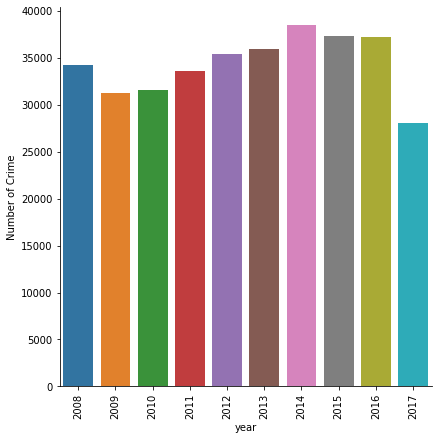

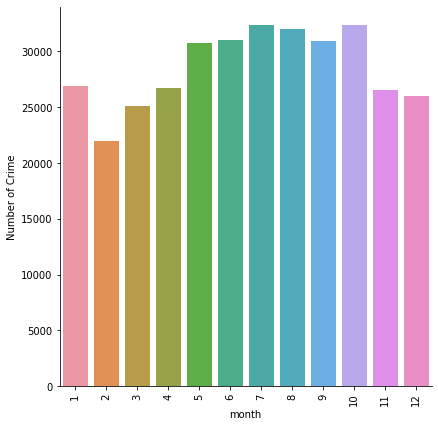

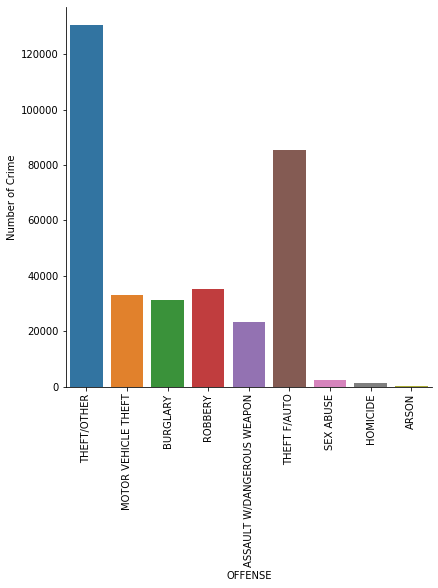

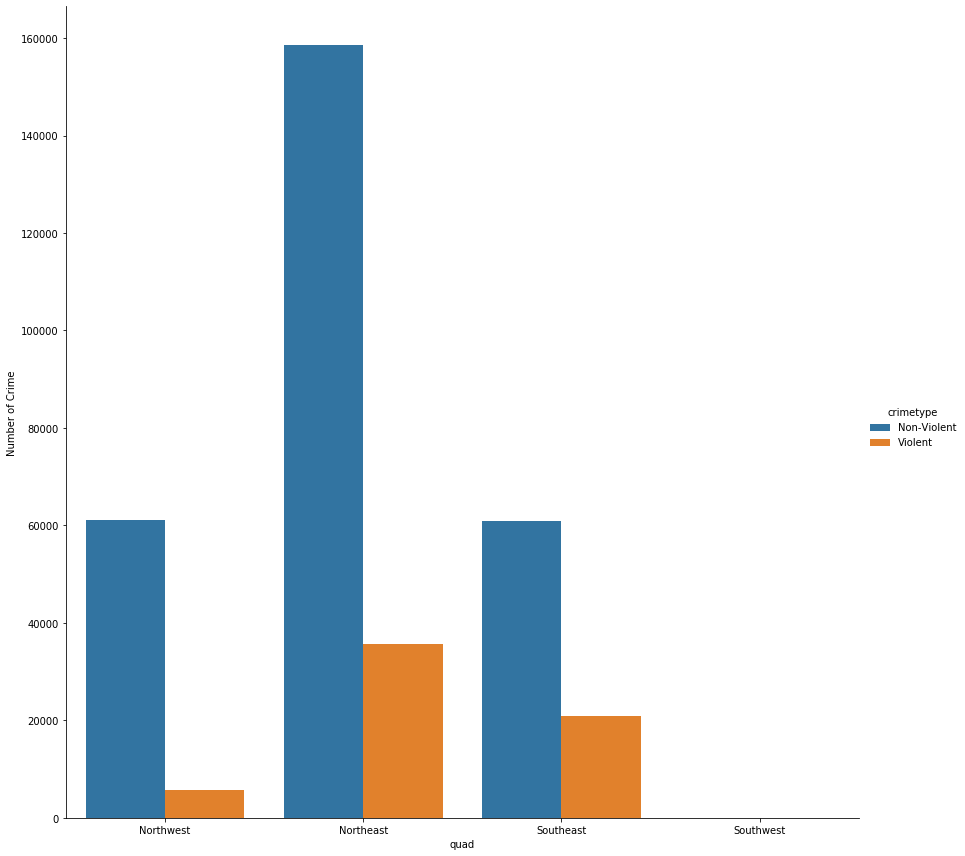

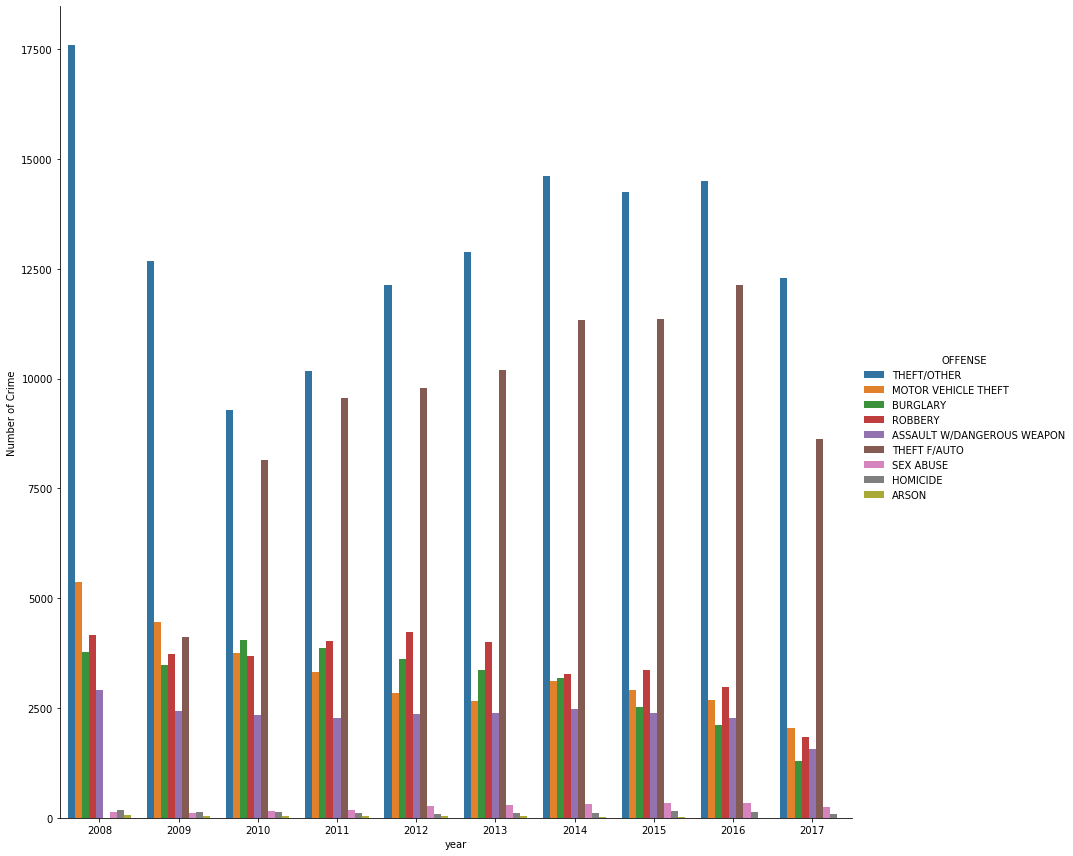

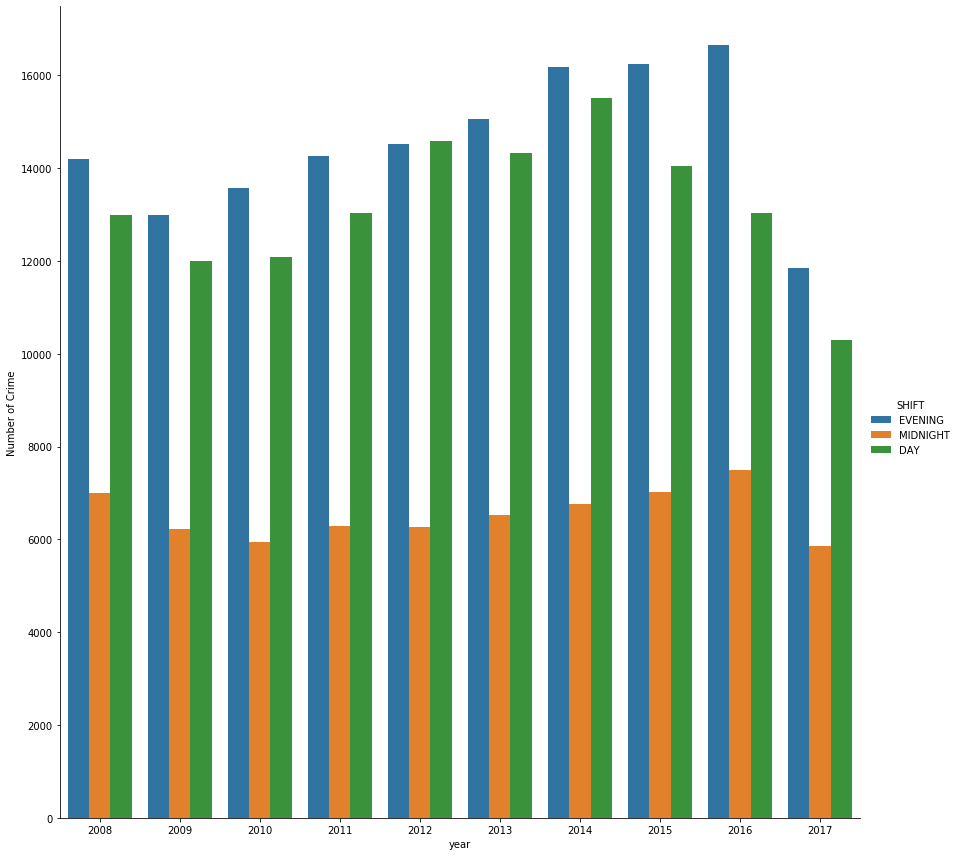

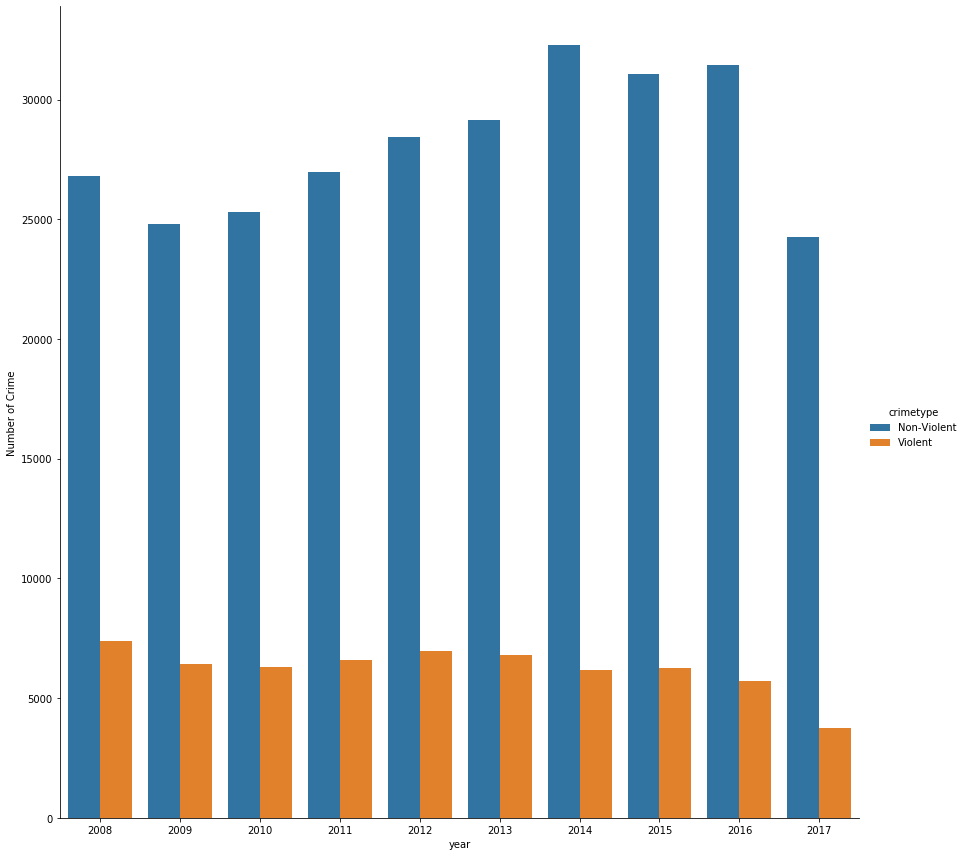

In [19]:
bar_plot('year', 'Number of Crime')
bar_plot('month','Number of Crime')
bar_plot('OFFENSE','Number of Crime')

# breakdown of quadrants with crime count (10-year period)
three_plot('quad', 'crimetype','Number of Crime')   

# crime pattern based on day week (10-year period)
# three_plot('day_week', 'New_Offense', 'Number of Crime')

# breakdown of the type of offense (10-year period)
three_plot('year','OFFENSE', 'Number of Crime')

# breakdown of crime pattern based on shift (10-year period)
three_plot('year','SHIFT','Number of Crime')

# breakdown of violent and non-violent crime (10-year period)
three_plot('year','crimetype','Number of Crime')

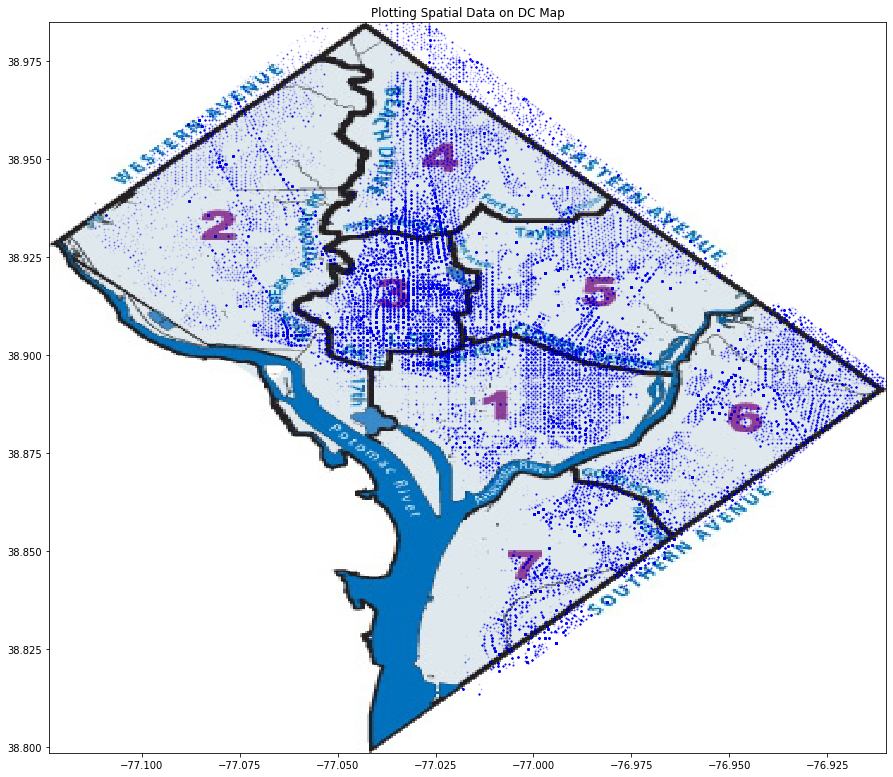

In [47]:
# Creating Spatial Map
# General Spatial Data of Crimes in DC over 10-year period

BBox = ((crimeDF.XBLOCK.min()-0.01, crimeDF.XBLOCK.max(),      
         crimeDF.YBLOCK.min()-0.015, crimeDF.YBLOCK.max()-0.01))
BBox

dc_map = plt.imread('DC_MPD_District_Map.jpg')

fig, ax = plt.subplots(figsize = (15,16))
ax.scatter(crimeDF.XBLOCK, crimeDF.YBLOCK, zorder=1, alpha= 0.05, c='b', s=1.1)
ax.set_title('Plotting Spatial Data on DC Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(dc_map, zorder=0, extent= BBox, aspect='equal')